In [ ]:
import sys
sys.path.append('../30_data_tools/')

In [41]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy.stats import chisquare
from sklearn import preprocessing
import re
from tqdm.auto import tqdm

In [3]:
from PIL import Image
import numpy as np
import sqlite3
from pathlib import Path
import json
from sklearn.preprocessing import LabelEncoder

In [4]:
from helper import load_dotenv
from get_labelstudio_data import get_results_of_project

In [5]:
def group_by( selection, group_by_features ):
    grouped = selection.loc[
        :,
        [*group_by_features,'label','mask_id']
    ].groupby([
        *[feature if feature != 'timestamp' else pd.Grouper(key='timestamp', freq="d") for feature in group_by_features],
        'label'
    ]).count().unstack('label')
    
    grouped.columns = [c[1] for c in grouped.columns]
    grouped.loc[:,'moire_ratio'] = grouped.checked_moire / (
        grouped.checked_moire + 
        grouped.checked_no_moire +
        grouped.ssim_no_moire
    )
    grouped.loc[:,'total_count'] = (
        grouped.checked_moire + 
        grouped.checked_no_moire +
        grouped.ssim_no_moire
    )

    return grouped

In [6]:
COLOR_MAP = {
    'checked_moire': '#db5561',
    'checked_no_moire': '#627a8e',
    'ssim_no_moire' : '#96aec3',
    True : '#db5561',
    False : '#84a6c4'
}

COLOR_SEQUENCE = [
    '#627a8e',
    '#96aec3',
    '#cce5fc'
]

In [7]:
dotenv = load_dotenv()
con = sqlite3.connect( dotenv['DB_PATH'] )

In [8]:
masks = pd.merge(
    pd.read_sql(
        '''
            SELECT m.*, gi.timestamp, gi.config_name FROM mask m
            LEFT JOIN generic_image gi
            ON
            	m.job=gi.job AND
            	m.pdf_filename=gi.pdf_filename AND
            	m.idx = gi.idx AND 
            	m.variant_name = gi.variant_name AND 
            	m."type" = gi."type" 
        ''',
        con,
        parse_dates=['timestamp']
    ),
    pd.DataFrame(
        [(r['id'],r['labels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','label']
    ),
    how="left",
    on="mask_id"
)

masks.loc[
    (pd.isna(masks.label)) & (masks.ssim >= 0.95),
    'label'
] = 'ssim_no_moire'

masks.loc[
    :,
    'pattern_shape'
] = masks.pattern.apply( lambda val: val.split('.')[-1] )


# set plain or perlin
masks.loc[
    masks.pattern.str.startswith('plain_'),
    'cover_style'
] = 'plain'

masks.loc[
    masks.pattern.str.startswith('perlin_'),
    'cover_style'
] = 'perlin'

masks.cover_style.fillna('legacy', inplace=True)


masks.loc[
    masks.pattern.str.startswith('plain_'),
    'pattern_coverage'
] = masks.loc[
    masks.pattern.str.startswith('plain_')
].pattern.apply(lambda val: (10 - int(re.search(r'plain_(\d+)\.+',val).groups()[0])) / 10 )

In [33]:
attachment_dir = dotenv['ATTACHMENT_DIR'] / 'auswertung_moireerzeugung'

# Moirérate

In [ ]:
masks.label.value_counts()

In [ ]:
masks.label.value_counts().checked_moire / masks.shape[0]

In [ ]:
grouped_by_timestamp = masks.loc[
    :,
    ['timestamp','label','mask_id']
].groupby([
    pd.Grouper(key="timestamp", freq="d"),
    'label'
]).count().unstack('label')
grouped_by_timestamp.columns = [c[1] for c in grouped_by_timestamp.columns]
grouped_by_timestamp.loc[:,'moire_ratio'] = grouped_by_timestamp.checked_moire / (
    grouped_by_timestamp.checked_moire + 
    grouped_by_timestamp.checked_no_moire +
    grouped_by_timestamp.ssim_no_moire
)

In [ ]:
px.bar(
    grouped_by_timestamp.moire_ratio,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

In [ ]:
grouped_by_config = group_by(
    masks.loc[
        pd.isna(masks.config_name) == False
    ],
    ['config_name']
)

In [ ]:
grouped_by_config

In [ ]:
fig = px.bar(
    grouped_by_config.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ],
    labels={
        'config_name' : 'verwendete Konfiguration',
        'value' : 'Anteil der erzeugten Masken mit Moiré',
        'variable' : 'Legende'
    },
    color_discrete_map=COLOR_MAP
)

#fig.update_layout(showlegend=False)
fig.write_image( attachment_dir / 'moire_rate_pro_config.jpg' )
fig

# Gruppiert nach verwendetem Pattern

In [ ]:
grouped_by_pattern = group_by(
    masks,
    ['pattern']
)

In [ ]:
grouped_by_pattern

In [ ]:
px.bar(
    grouped_by_pattern.sort_values('moire_ratio', ascending=False ).moire_ratio,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

## Perlin

In [ ]:
grouped_by_perlin = pd.concat(
    [
        group_by(
            masks.loc[masks.pattern.str.startswith('perlin_')],
            ['pattern']
        ).loc[
            :,
            ['checked_moire','checked_no_moire','ssim_no_moire','total_count']
        ].sum().to_frame().T,
        group_by(
            masks.loc[masks.pattern.str.startswith('perlin_') == False],
            ['pattern']
        ).loc[
            :,
            ['checked_moire','checked_no_moire','ssim_no_moire','total_count']
        ].sum().to_frame().T
    ],
    ignore_index=True
).rename(index={0: 'perlin', 1: 'plain'})

grouped_by_perlin.loc[:,'moire_ratio'] = grouped_by_perlin.checked_moire / (
    grouped_by_perlin.checked_moire + 
    grouped_by_perlin.checked_no_moire +
    grouped_by_perlin.ssim_no_moire
)

In [ ]:
grouped_by_perlin

In [ ]:
fig = px.bar(
    grouped_by_perlin.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ],
    labels={
        'index' : 'Verteilung der Flächendeckung in der Patternvorlage',
        'value' : 'Moirérate'
    },
    color_discrete_map=COLOR_MAP
)
fig.update_layout( showlegend=False )
fig.write_image( attachment_dir / 'grouped_by_perlin.jpg' )

fig

In [ ]:
px.bar(
    grouped_by_perlin.moire_ratio
).write_image( attachment_dir / 'grouped_by_perlin.jpg' )

## Form

In [ ]:
grouped_by_shape_form = group_by(
    masks.loc[masks.pattern_shape.isin(['LINE','CIRCLE','DIAMOND'])],
    ['pattern_shape']
)

In [ ]:
grouped_by_shape_form

In [ ]:
fig = px.bar(
    grouped_by_shape_form.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ],
    labels={
        'value' : 'Moirérate',
        'pattern_shape' : 'Patternvorlage Mustergrundform'
    },
    color_discrete_map=COLOR_MAP
)
fig.write_image( attachment_dir / 'grouped_by_shape_form.jpg' )

fig

## Flächendeckung

In [ ]:
grouped_by_pattern_coverage = group_by(
    masks.loc[masks.pattern.str.startswith('plain_')],
    ['pattern_coverage']
)

In [ ]:
px.bar(
    grouped_by_pattern_coverage.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ],
    labels={
        'value' : 'Moirérate',
        'pattern_coverage' : 'Flächendeckung der Patternvorlage'
    },
    color_discrete_map=COLOR_MAP
).write_image( attachment_dir / 'grouped_by_pattern_coverage.jpg' )

In [ ]:
grouped_by_pattern_coverage_and_shape = group_by(
    masks.loc[masks.pattern.str.startswith('plain_')],
    ['pattern_coverage','pattern_shape']
).fillna(0).moire_ratio.unstack('pattern_shape')

In [ ]:
group_by(
    masks.loc[masks.pattern.str.startswith('plain_')],
    ['pattern_coverage','pattern_shape']
).fillna(0)

In [ ]:
px.line(
    grouped_by_pattern_coverage_and_shape
)

In [ ]:
grouped_by_pattern_coverage.moire_ratio

# allgemeine Zusammenhänge

In [ ]:
masks.ssim.describe()

In [ ]:
px.scatter(
    masks.ssim.sort_values().reset_index().loc[:,'ssim']
)

In [ ]:
data.shape

In [ ]:
data.loc[
    :,
    [c for c in data.columns if c.startswith('use_')]
].sum()

In [ ]:
data.loc[
    :,
    'area'
] = data.bbox.apply(lambda val: val[2] * val[3])

In [ ]:
data.loc[
    :,
    ['ssim','area']
].corr()

In [ ]:
df= data.loc[
    :,
    'ssim'
].to_frame()

df.loc[
    :,
    'pattern'
] = pd.factorize(data.pattern)[0]

In [ ]:
df.corr('spearman')

In [ ]:
df.corr('pearson')

# Zusammehang: ssim und Flächedeckung

In [ ]:
def get_edge_share( row, edge_limit ):
    img = Image.open( row.img_path ).crop((
        row.bbox[0],
        row.bbox[1],
        row.bbox[0] + row.bbox[2],
        row.bbox[1] + row.bbox[3]
    ))

    k_separation = np.array(img)[:,:,3]
    relevant_part = k_separation[(k_separation < edge_limit) | (k_separation > (255 - edge_limit))]

    return relevant_part.shape[0] / (k_separation.shape[0] * k_separation.shape[1])

In [ ]:
data.loc[
    :,
    'edge_share'
] = data.apply( get_edge_share, args=(10,), axis=1 )

In [ ]:
edge_share = data.edge_share #returns a numpy array
edge_share_normalized = preprocessing.MinMaxScaler().fit_transform(edge_share.to_numpy().reshape((-1,1)))

ssim = data.ssim #returns a numpy array
ssim_normalized = preprocessing.MinMaxScaler().fit_transform(ssim.to_numpy().reshape((-1,1)))

In [ ]:
data.loc[
    :,
    'edge_share_normalized'
] = edge_share_normalized

data.loc[
    :,
    'ssim_normalized'
] = ssim_normalized

In [ ]:
data.loc[
    :,
    ['ssim','edge_share']
].corr()

In [ ]:
data.loc[
    :,
    ['ssim_normalized','edge_share_normalized']
].corr()

In [ ]:
data.iloc[0].img_path

# Kategorien von Masken

In [9]:
data = pd.merge(
    pd.read_sql(
        '''
            SELECT apm.*, m.overlay_intensity_K, m.ssim, m.bbox, gi."timestamp" FROM adjustment_per_mask apm 
            LEFT JOIN mask m
            ON
            	apm.pdf_filename = m.pdf_filename AND
            	apm.job = m.job AND
            	apm."type" = m."type" AND 
            	apm.variant_name = m.variant_name AND 
            	apm."method" = m."method" AND 
            	apm.idx = m.idx AND 
            	apm.mask_id = m.mask_id 
            LEFT JOIN generic_image gi 
            ON
            	apm.pdf_filename = gi.pdf_filename AND
            	apm.job = gi.job AND
            	apm."type" = gi."type" AND 
            	apm.variant_name = gi.variant_name AND 
            	apm."method" = gi."method" AND 
            	apm.idx = gi.idx 
        ''',
        con,
        parse_dates=['timestamp']
    ),
    pd.DataFrame(
        [(r['id'],r['labels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','label']
    ),
    how="left",
    on="mask_id"
)

data.loc[
    (data.ssim > 0.95),
    'label'
] = 'ssim_no_moire'

In [ ]:
data.shape

In [ ]:
data.loc[data.mask_id.str.startswith('temp_')].shape

In [ ]:
grouped_by_mask_id = data.loc[
    :,
    ['mask_id','job']
].groupby(
    'mask_id'
).count().rename(columns={'job':'adjustment_count'})

In [ ]:
fig = px.bar(
    grouped_by_mask_id.adjustment_count.value_counts().sort_index(),
    labels={
        "value" : 'Anzahl an Objektkacheln',
        'index' : 'Anzahl angewendete Effekte pro Objektkachel'
    },
    color_discrete_sequence=COLOR_SEQUENCE
)
fig.update_layout(showlegend=False)
fig.write_image( attachment_dir / 'effekte_pro_kachel.jpg' )

## Rotation

In [ ]:
from scipy import stats

In [ ]:
le_rotation = LabelEncoder()
le_rotation.fit(data.loc[
    data.adjustment == 'rotation'
].label.tolist())

In [ ]:
X = data.loc[
    data.adjustment == 'rotation'
].features.apply( lambda val: json.loads(val)['rotation_degree'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'rotation'
].label.tolist())

stats.pearsonr(X, y)

In [ ]:
round(stats.pearsonr(X, y).pvalue,3)

In [35]:
px.scatter(
    y=data.loc[
        data.adjustment == 'rotation'
    ].features.apply( lambda val: json.loads(val)['rotation_degree'] ),
    color=data.loc[
        data.adjustment == 'rotation'
    ].label,
    color_discrete_map=COLOR_MAP,
    labels={
        "x" : "Rotationseffekte",
        'y' : 'Winkel'
    }
).write_image( attachment_dir / 'rotation.jpg' )

## Skalierung

In [10]:
from get_feature_importance_df import get_scale_data

In [11]:
X = data.loc[
    data.adjustment == 'scale'
].features.apply( lambda val: json.loads(val)['scale'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'scale'
].label.tolist())

stats.pearsonr(X, y)

NameError: name 'le' is not defined

In [25]:
scale_data = pd.merge(
    get_scale_data( data ),
    data.loc[:,['mask_id','label']].drop_duplicates(),
    how="left",
    on="mask_id"
)

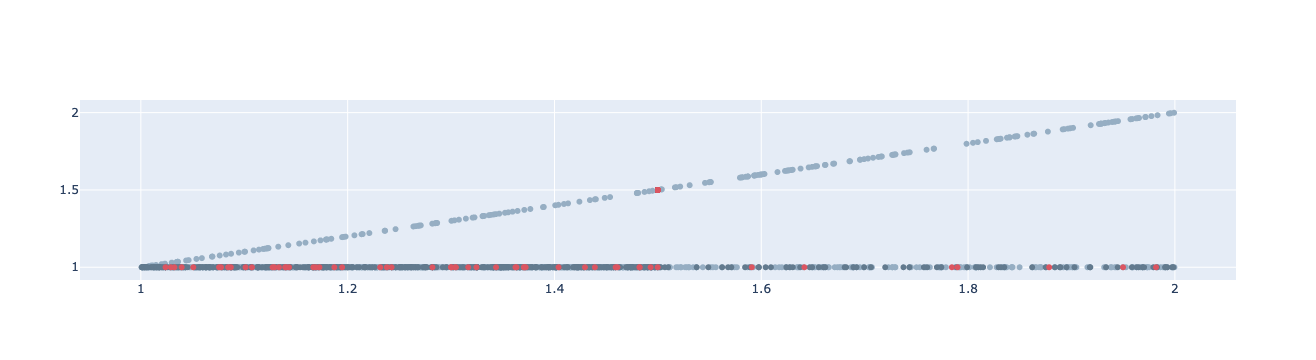

In [53]:
fig = go.Figure()
fig.add_traces([
    go.Scatter(
        name='Upper Bound',
        x=scale_data.loc[scale_data.label == 'ssim_no_moire'].stretch_x,
        y=scale_data.loc[scale_data.label == 'ssim_no_moire'].stretch_y,
        mode='markers',
        marker=dict(color=COLOR_MAP['ssim_no_moire']),
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=scale_data.loc[scale_data.label == 'checked_no_moire'].stretch_x,
        y=scale_data.loc[scale_data.label == 'checked_no_moire'].stretch_y,
        line=dict(width=1),
        mode='markers',
        marker=dict(color=COLOR_MAP['checked_no_moire']),
        showlegend=False
    ),
    go.Scatter(
        x=scale_data.loc[scale_data.label == 'checked_moire'].stretch_x,
        y=scale_data.loc[scale_data.label == 'checked_moire'].stretch_y,
        mode='markers',
        marker=dict(color=COLOR_MAP['checked_moire']),
        showlegend=False
    )
])

fig.write_image( attachment_dir / 'skalierung.jpg' )

fig

# perspektivische Verzerrung

In [ ]:
px.scatter(
    y=data.loc[
        data.adjustment == 'uniform_trapezoidal_distortion'
    ].features.apply( lambda val: json.loads(val)['trapezoidal_distortion_strength'] ),
    color=data.loc[
        data.adjustment == 'uniform_trapezoidal_distortion'
    ].label == 'checked_moire'
)

In [ ]:
X = data.loc[
    data.adjustment == 'uniform_trapezoidal_distortion'
].features.apply( lambda val: json.loads(val)['trapezoidal_distortion_strength'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'uniform_trapezoidal_distortion'
].label.tolist())

stats.pearsonr(X, y)

# Regression

In [ ]:
from get_feature_importance_df import get_feature_importance_df, get_scale_data
from sklearn.ensemble import RandomForestClassifier

In [ ]:
regression_data = get_feature_importance_df( masks, data )
regression_data.label = (regression_data.label == 'checked_moire').astype('int')

In [ ]:
clf.feature_importances_.shape

In [ ]:
rows = []

for i in tqdm(range(25)):
    sample = regression_data.sample(frac=.8)

    X = sample.loc[
        :,
        [c for c in sample.columns if c not in ['label','mask_id','ssim']]
    ].to_numpy()
    y = sample.loc[:,'label'].to_numpy()

    clf = RandomForestClassifier(max_depth=10, random_state=0)
    clf.fit(X, y)

    row = {
        'score' : clf.score(X, y)
    }

    i = 0
    for c in regression_data.columns:        
        if c not in ['label','mask_id','ssim']:
            row[c] = clf.feature_importances_[i]
            i += 1

    rows.append(row)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(clf, X, y, n_repeats=10,random_state=0)
result.importances_mean
result.importances_std

In [ ]:
px.bar(
    y=result.importances_mean,
    error_y=result.importances_std
)

In [ ]:
result_frame = pd.DataFrame.from_dict(rows)

In [ ]:
result_frame.score.describe()

In [ ]:
(result_frame.loc[:,[c for c in result_frame.columns if c != 'score']].std() / result_frame.loc[:,[c for c in result_frame.columns if c != 'score']].mean()).mean()

In [ ]:
fig = px.bar(
    x=result_frame.loc[:,[c for c in result_frame.columns if c != 'score']].columns,
    y=result_frame.loc[:,[c for c in result_frame.columns if c != 'score']].mean().values,
    error_y=result_frame.loc[:,[c for c in result_frame.columns if c != 'score']].std().values,
    color_discrete_sequence=COLOR_SEQUENCE,
    labels={
        'y' : 'Einfluss des Features',
        'x' : ''
    }
)
fig.update_xaxes(tickmode='linear')
fig.write_image( attachment_dir / 'feature_importance.jpg' )

fig